In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
from scipy.optimize import curve_fit
from scipy.stats.distributions import t
from scipy.optimize import minimize
from scipy import stats
import scipy.optimize as optimize
from scipy.optimize import fsolve

**Non-linear Fitting to Determine the Model Parameters k, Kb , and Kt**

You can download Fogler's book from here: https://doku.pub/download/h-scott-fogler-essentials-of-chemical-reaction-engineering-z0x2ze484wqn

In [2]:
# observed experimental reaction rates for the reaction C6H5CH3 + H2 → C6H6 + CH4 or t + h → b + m
data = pd.DataFrame({
"r":[71, 71.3, 41.6, 19.7, 42.0, 17.1, 71.8, 142.0, 284.0, 47.0, 71.3, 117.0, 127.0, 131.0, 133.0, 41.8], 
"t":[1, 1, 1, 1, 1, 1, 1, 1, 1, 0.5, 1,5, 10, 15, 20, 1], 
"h":[1, 1, 1, 1, 1, 1, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1],
"m":[1, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 
"b":[0, 0, 1, 4, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
})

# multiple independent variables - partial pressures of components
x_data = data.iloc[:, 1:].T.values

# dependent variable - rate of reaction
y_observed = data["r"]

In [3]:
# calculate y
def calc_y(x, k, Kb, Kt):
    
    num = k*x[0]*x[1]
    denom = 1+Kb*x[3]+Kt*x[0]
    y = num/denom #(mol/kg_cat.s)
    
    return y

my_model = Model(calc_y)

# set the boundries for each parameter
# my_model.set_param_hint('k', min=0, max=np.inf)
# my_model.set_param_hint('Kb', min=0, max=np.inf)
# my_model.set_param_hint('Kt', min=0, max=np.inf)

# initial values
result = my_model.fit(y_observed, x=x_data, k=1e5, Kb=0.01, Kt=0.01)

print(result.fit_report())

best_values = result.best_values
best_fit = result.best_fit

slope, intercept, r_value, p_value, std_err = stats.linregress(y_observed, best_fit)
    
# if r2 value is not close to one change the initial values
r2 = r_value**2
print('---------------------------------------------------------')
print('The value of r2 between the y_observed and y_calc is:', r2)

[[Model]]
    Model(calc_y)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 16
    # variables        = 3
    chi-square         = 3.26050902
    reduced chi-square = 0.25080839
    Akaike info crit   = -19.4512864
    Bayesian info crit = -17.1335202
    R-squared          = 0.99995092
[[Variables]]
    k:   144.767309 +/- 0.57428110 (0.40%) (init = 100000)
    Kb:  1.39052653 +/- 0.02120298 (1.52%) (init = 0.01)
    Kt:  1.03841056 +/- 0.00609302 (0.59%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, Kt)  = +0.9568
    C(k, Kb)  = +0.3432
    C(Kb, Kt) = +0.3094
---------------------------------------------------------
The value of r2 between the y_observed and y_calc is: 0.999953025267843


# 2nd method using curve_fit

In [4]:
# mol/kg_cat.s
def rate(x, *params):
    
    k, Kb, Kt = params
    
    num = k*x[0]*x[1]
    denom = 1+Kb*x[3]+Kt*x[0]
    y = num/denom            
    
    return y

bnds = [0, [np.inf, np.inf, np.inf]]
    
popt, pcov = curve_fit(rate, x_data, y_observed, p0 =[1e05, 1.0, 1.0], 
bounds = bnds)

#k value needs to be multiplied by 10^-10
k, Kb, Kt = popt

k_rate_constant = k*1e-10

residuals = rate(x_data, *popt) - y_observed
rss = sum(residuals**2)

y_mean = np.mean(y_observed)
total_residuals = y_mean - y_observed
tss = sum(total_residuals**2)

n = len(y_observed) # number of data points
p = len(popt) # number of parameters
alpha = 0.05

dof = max(0, n - p) #number of degrees of freedom

r_squared = 1 - (rss/tss)
r_adjusted = 1 - ((1 - r_squared)*(n - 1))/(n - p - 1)

tinv = lambda alpha, dof: abs(t.ppf(1.0 - alpha/2, dof)) 
tval = tinv(alpha, dof)

#confidence level for the estimated parameters

dfit = np.sqrt(np.diag(pcov))
for i, j, var in zip(range(n), popt, dfit):
    print('j{0}: {1} [{2} {3}]'.format(i, j, j - var*tval, j + var*tval))
    
variance = rss/dof

rmse = (rss/n)**0.5

print("The rate constant value is: ", k_rate_constant)
print("The equilibrium constant of product b is", Kb)
print("The equilibrium constant of product t is", Kt)
print("The R squared value is:", r_squared)
print("The R_adjusted value is: ", r_adjusted)
print("The root mean square error (RMSE) or (RMSD) is", rmse)
print("The variance is", variance)

j0: 144.76730784256213 [143.52665713100265 146.00795855412161]
j1: 1.390526436350292 [1.3447204265100068 1.4363324461905773]
j2: 1.0384105580616636 [1.0252475855209613 1.051573530602366]
The rate constant value is:  1.4476730784256213e-08
The equilibrium constant of product b is 1.390526436350292
The equilibrium constant of product t is 1.0384105580616636
The R squared value is: 0.9999509157577747
The R_adjusted value is:  0.9999386446972184
The root mean square error (RMSE) or (RMSD) is 0.4514219906819957
The variance is 0.2508083860569794


# 3rd method using 'BFGS'

In [5]:
def kinet_params(data):

    y_calc = lambda x, k: k[0]*x[0]*x[1]/(1+k[1]*x[3]+k[2]*x[0])

    # Error function
    errFunc = lambda k, x, y: y_calc(x, k) - y

    # Error of parameters
    def errFit(hess_inv, resVariance):
        
        return np.sqrt(np.diag(hess_inv * resVariance))

    kstart = [0, 100, 0]
    
    # minimize, note that 'BFGS' method cannot handle bounds
    result = minimize(lambda k, x, y, f: np.linalg.norm(y - f(x, k)), 
                      kstart, 
                      args=(x_data, y_observed, y_calc), 
                      method = 'BFGS')
    
    dFit = errFit(result.hess_inv, result.fun/(len(y_observed)-len(kstart)))
    
    # best estimated parameters
    k = result.x
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_observed, y_calc(x_data, k))
    
    # if r2 value is not close to one change the initial values
    r2 = r_value**2
    
    # 95% confidence interval
    alpha = 0.05
    dof = max(0, len(y_observed) - len(k))
    
    tinv = lambda alpha, dof: abs(t.ppf(1.0 - alpha/2, dof))
    tval = tinv(alpha, dof)
    
    for i, j, var in zip(range(len(y_observed)), k, dFit):
        
        print('j{0}: {1} [{2}  {3}]'.format(i, j, j - var*tval, j + var*tval))

    return k, r2

kinet_params(data)

j0: 144.7673005996489 [143.52960899059954  146.00499220869827]
j1: 1.3905263403326882 [1.3443241768934888  1.4367285037718875]
j2: 1.038410477134909 [1.0251858763190675  1.0516350779507504]


(array([144.7673006 ,   1.39052634,   1.03841048]), 0.9999530252392126)

# 4th method using 'SLSQP'

array([144.76730315,   1.39052644,   1.03841053])

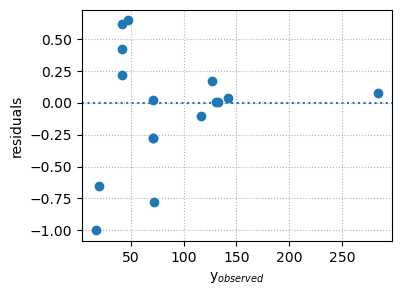

In [6]:
y_calc = lambda x, *k: k[0]*x[0]*x[1]/(1+k[1]*x[3]+k[2]*x[0])

bnds = [(0.0, 200), (0.0, 10), (0.0, 10)]

root = fsolve(lambda k: y_calc(x_data[:, :3], *k), [1, 1, 1]) # for estimating initial guess

sol = minimize(lambda k, x, y, f: np.linalg.norm(y - f(x, *k)),
               root,
               args=(x_data, y_observed, y_calc), 
               method='SLSQP',
               bounds=bnds)

fig, ax = plt.subplots(figsize = (4,3))

ax.plot(y_observed, y_calc(x_data, *sol.x) - y_observed, 'o')
ax.set_xlabel('y$_{observed}$')
ax.set_ylabel('residuals')
ax.axhline(y = 0, linestyle = ":")
ax.grid(linestyle = ':')

sol.x

# 5th method with residuals plots

k  =  144.76736202802255
Kb  =  1.390528638665779
Kt  =  1.038410905746793


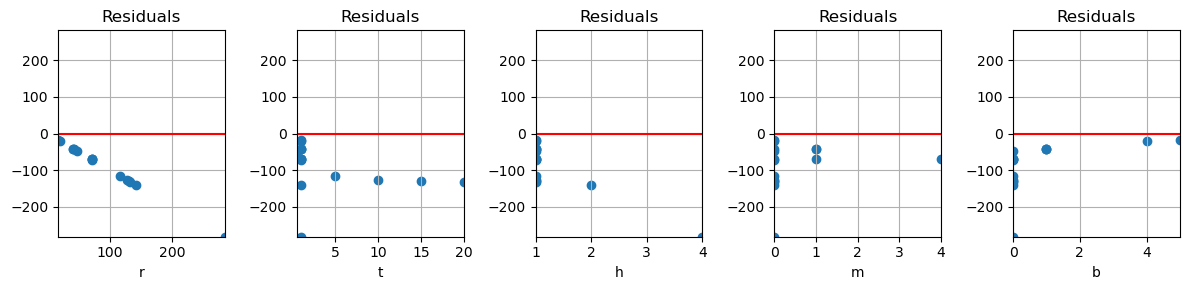

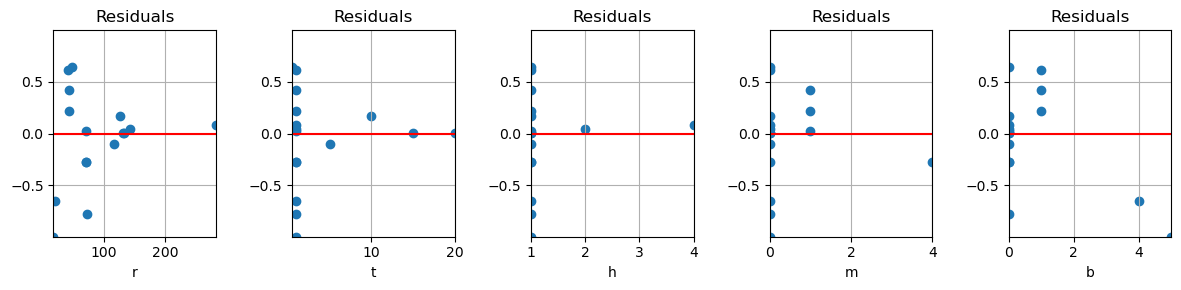

In [7]:
def fun(x, *params):
    
    k, Kb, Kt = params
    
    num = k*x[0]*x[1]
    denom = 1+Kb*x[3]+Kt*x[0]
    y = num/denom 
    
    return y


def residuals(params, x, y):
    
    return fun(x, *params) - y


def min_fun(params, x, y, f):
    
    return np.linalg.norm(y - f(x, *params))
  
parameter_names = ['k', 'Kb', 'Kt']
parameter_guess = [1, 1, 1]
parameter_bounds = [(0.0, 200), (0.0, 10), (0.0, 10)]

###################################################################
def plot_residuals(r, data, ax=None):
    rmax = np.max(np.abs(r))
    if ax is None:
        fig, ax = plt.subplots(1, len(data.columns), figsize=(12,3))
    else:
        rmax = max(ax[0].get_ylim()[1], rmax)
    n = 0
    for c in data.columns:
        ax[n].scatter(data[c], r)
        ax[n].set_ylim(-rmax, rmax)
        ax[n].set_xlim(min(data[c]), max(data[c]))
        ax[n].plot(ax[n].get_xlim(), [0,0], 'r')
        ax[n].set_xlabel(c)
        ax[n].set_title('Residuals') 
        ax[n].grid(True)
        n += 1
    plt.tight_layout()
###################################################################

sol = minimize(min_fun, 
               parameter_guess, 
               args=(x_data, y_observed, fun), 
               method='SLSQP',
               bounds=parameter_bounds)

for name, value in zip(parameter_names, sol.x):
    print(name, " = ", value)

r = residuals(parameter_guess, x_data, y_observed)    
ax = plot_residuals(r, data)

r_best = residuals(sol.x, x_data, y_observed)
plot_residuals(r_best, data, ax=ax)